# NLP project


Project 21: Automatic Summarization  

We shall consider structured document containing a title, abstract and a set of subsections. We would like to build a text summarizer such that tracks important keywords in the document. For this purpose, the first step is identify these keywords.  

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


'c:\program' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip list
#tarkista löytyykö: lxml, html5lib, requests

Package            Version
------------------ ---------
aiohttp            3.6.2
astroid            2.3.3
async-timeout      3.0.1
atomicwrites       1.3.0
attrs              19.3.0
autopep8           1.5
backcall           0.1.0
beautifulsoup4     4.8.2
bleach             3.1.3
blis               0.7.4
catalogue          2.0.6
certifi            2019.6.16
cffi               1.14.0
chardet            3.0.4
click              8.0.1
colorama           0.4.1
coverage           5.0.3
cycler             0.10.0
cymem              2.0.5
decorator          4.4.2
defusedxml         0.6.0
discord.py         1.5.1
en-core-web-sm     3.1.0
entrypoints        0.3
ffmpeg             1.4
ffmpeg-python      0.2.0
flake8             3.7.9
flake8-polyfill    1.0.2
future             0.17.1
graphviz           0.13.2
idna               2.8
importlib-metadata 1.5.0
ipykernel          5.2.0
ipython            7.13.0
ipython-genutils   0.2.0
ipywidgets         7.5.1
isort              4.3.21
jedi            

In [3]:
#jos nltk ei löydy asenna -> ! pip install nltk
import nltk
nltk.download("stopwords")
#from nltk.cluster.util import cosine_distance

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lassi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## TASK 1
Assume the initial input is given as html document (choose an example of your own), we hypothesize that important keywords are initially contained in the words of titles, abstract and possibly titles of subsections of the document. Suggest a simple python script that inputs an html document and outputs the lists of words in the title, abstract and title of section/subsections.

In [4]:
from bs4 import BeautifulSoup
import requests

#Collect title, subtitles and abstract from html file

url = "https://www.iltalehti.fi/saauutiset/a/7095598c-3893-43ee-99fd-9b9cca404757" 

source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')
#jos saat errorin -> FeatureNotFound, pakko päivitä lxml käskyllä -> pip install lxml --upgrade

article = soup.find('article')
#print(article.prettify())


headline = article.find('div', class_="article-content").h1.text

print('>Title:\n{0} \n'.format(headline))

subheadlines = article.find_all("h3", {'class':'subheadline'})
print('>Subheadlines:')
for subheadline in subheadlines:
    print(subheadline.text)
    
summary = article.find_all("div", {'class':'article-bullets'})
print('\n>Bullet points:')
for bullet in summary:
    print("{}\n".format(bullet.text))
    
text = article.find_all('p', {'class':'paragraph'})
print('\n>Article:')
for line in text:
    print(line.text)



>Title:
"Saattaa olla hiutaleita" – tältä näyttää syyslomaviikkojen sää 

>Subheadlines:
Viikko 41
Viikko 42
Viikko 43
Sateiden joukossa hiutaleita

>Bullet points:
Koulujen syyslomia vietetään eri puolilla Suomea viikoilla 41, 42, 43.Sää viilenee kovaa vauhtia.Tilastojen mukaan kuun loppupuolella voidaan saada jo ehjä väliaikainen lumipeite ainakin Lapissa.


>Article:
Koulujen syyslomaviikkoja vietetään taas seuraavien kolmen viikon ajan ympäri Suomea. Viikolla 41 pääsevät lomailemaan turkulaiset, minkä jälkeen muualla puolen Suomea koululaiset lomailevat porrastetusti viikoilla 42 ja 43.
Sää jokaiselle kolmelle viikolle näyttää hyvin perinteiseltä syyssäältä, hieman sateita, tuulta ja viileämpiä lämpötiloja.
Jos haluat jatkossa seurata tarkemmin sään kehittymistä ja ennusteita, lataa älypuhelimeesi Iltalehden Paras Sää -sovellus.
Koko viikko on oikeastaan melko pilvinen ja sateinen, kertoo Forecan meteorologi Joanna Rinne.
Lämpötila on suurimmassa osassa maata 8–10 astetta viikon ai

In [5]:
text = headline + " "
for i in subheadline:
    text + i + " "
    
text = text + bullet.text + " "

print(text)

"Saattaa olla hiutaleita" – tältä näyttää syyslomaviikkojen sää Koulujen syyslomia vietetään eri puolilla Suomea viikoilla 41, 42, 43.Sää viilenee kovaa vauhtia.Tilastojen mukaan kuun loppupuolella voidaan saada jo ehjä väliaikainen lumipeite ainakin Lapissa. 


In [6]:
import yake

In [7]:
#Keyword search and analysis

w_extractor = yake.KeywordExtractor()

language = "fi"
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 50 #alunperin 10

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)

for kw in keywords:
    print(kw)


('Suomea viikoilla', 0.023458380875189744)
('sää Koulujen', 0.04498862876540802)
('Koulujen syyslomia', 0.04498862876540802)
('puolilla Suomea', 0.04498862876540802)
('tältä näyttää', 0.04940384002065631)
('viilenee kovaa', 0.04940384002065631)
('Saattaa', 0.08596317751626563)
('Lapissa', 0.08596317751626563)
('näyttää syyslomaviikkojen', 0.09700399286574239)
('syyslomaviikkojen sää', 0.09700399286574239)
('syyslomia vietetään', 0.09700399286574239)
('kovaa vauhtia.Tilastojen', 0.09700399286574239)
('kuun loppupuolella', 0.09700399286574239)
('ehjä väliaikainen', 0.09700399286574239)
('väliaikainen lumipeite', 0.09700399286574239)
('Koulujen', 0.1447773057422032)
('Suomea', 0.1447773057422032)
('hiutaleita', 0.15831692877998726)
('tältä', 0.15831692877998726)
('viikoilla', 0.15831692877998726)
('viilenee', 0.15831692877998726)
('näyttää', 0.29736558256021506)
('syyslomaviikkojen', 0.29736558256021506)
('sää', 0.29736558256021506)
('syyslomia', 0.29736558256021506)
('vietetään', 0.29736

## TASK 2
Write down a simple python script that allows you to output the histogram of word frequency in the document, excluding the stopwords (see examples in online NLTK book). Use SpaCy named-entity tagger to identify person-named entities and organization-named entities in the document.

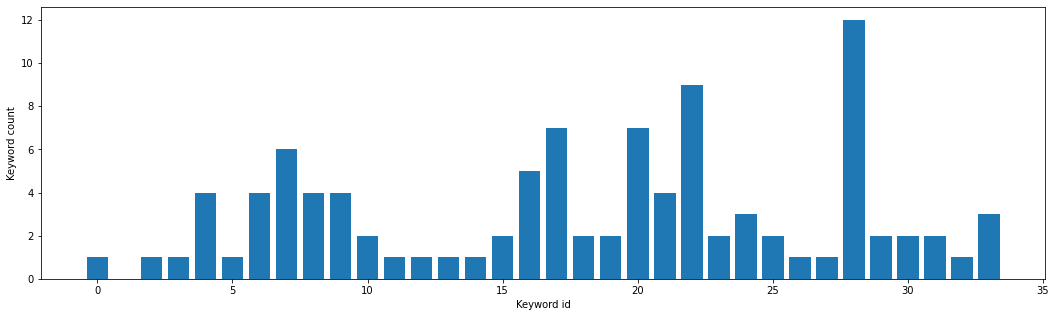

In [15]:
#from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

#Calculate the word frequencies and plot the histogram

#Purkkapallolla koko artikkeli -> string
article_readable = headline

article_readable += (article.find('div', class_="article-content").h1.text) + " "

subheadlines = article.find_all("h3", {'class':'subheadline'})
for subheadline in subheadlines:
    article_readable += subheadline.text

article_readable += article_readable + " "
    
summary = article.find_all("div", {'class':'article-bullets'})
for bullet in summary:
    article_readable += "{}\n".format(bullet.text)
    
text = article.find_all('p', {'class':'paragraph'})
for line in text:
    article_readable += line.text
    
#print(article_readable)
#Purkkapallo suoritettu

stopwords = stopwords.words("finnish")
#print(stopwords)

#Remove stopwords from the keywords list
keywords_only, keywords_nums = zip(*keywords) 
keywords_no_sw =  [word for word in keywords_only if not word in stopwords]
keywords_counts = []

for kw in keywords_no_sw:
    kw_count = article_readable.count(kw)
    keywords_counts.append(kw_count)

#print(keywords_no_sw)
#print(keywords_counts)
    
#Plotting the histogram
fig, ax = plt.subplots(figsize=(18,5))
plt.bar(np.arange(len(keywords_no_sw)), keywords_counts, align='center')
plt.ylabel('Keyword count')
plt.xlabel('Keyword id')
plt.show()

In [10]:
#Use SpaCy to identify person-named entities and organization-named entities
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

#vinkkiä https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

#Identifying person and organization-named entities
nlp = en_core_web_sm.load()
doc = nlp(article_readable)

for X in doc.ents:
    print("{} - {}".format(X.text, X.label_))


Koulujen - GPE
41 - CARDINAL
42 - DATE
43.Sää - CARDINAL
kuun loppupuolella voidaan saada jo - PERSON
Lapissa - PERSON
Koulujen - GPE
viikon ajan - PERSON
Suomea - ORG
minkä jälkeen muualla - PERSON
42 - CARDINAL
jokaiselle - GPE
kolmelle viikolle - PERSON
hieman sateita - PERSON
kehittymistä ja ennusteita - ORG
Koko - PERSON
melko pilvinen ja sateinen - PERSON
kertoo Forecan - PERSON
Joanna Rinne - PERSON
viikon aikana - PERSON
Lapissa - PERSON
jo lähelle viittä - ORG
kun - CARDINAL
tällä kuluvalla viikolla - ORG
Yölämpötilat - GPE
jo pakkasen puolella - PERSON
Rinne kertoo - PERSON
Hajanaisia - GPE
viikon ajan - PERSON
Rinne - PERSON
viikon kohdalla ennusteissa siirrytään - PERSON
Rinne - PERSON
Viikolla 42 - ORG
vietetään eri puolilla maata - ORG
esimerkiksi pääkaupunkiseudulla - GPE
Rovaniemellä - PERSON
lähellä keskiarvoa - ORG
kuin keskimääräisesti - PERSON
Rinne - PERSON
Hyvin - PERSON
Lokakuussa Suomen sää - PERSON
lähellä - ORG
ehkä pikkaisen - ORG
sateisempaa kuin vuodenaikaa

## TASK 3
We would like the summarizer contains at least the ten most frequent word and many named-entities. For this purpose, use the following heuristic to construct the summarizer. i) Identify the first sentence in the document that contains the highest frequent word. If such sentence is located in the title or abstract of the document, then extract this sentence to be included in the summarizer. Otherwise, we extract the first sentence in the document that contains both this highest frequent word and named-entity. If there is no sentence that contains this highest frequent word and named-entity (person or organization), then extract the first sentence that contains this highest frequent word. Repeat this process for each of the remaining top ten frequent word in the document. Finally, output the underlined sentences while respecting the order in which the sentences appear in the document.

## TASK 4
We would like the choice of keywords not based on histogram frequency but using the open source RAKE https://www.airpair.com/nlp/keyword-extraction-tutorial. Repeat the previous process of selecting the sentences that are associated to the ten first keywords generated by RAKE. Comment on the quality of this summarizer based on your observation